<a href="https://colab.research.google.com/github/wilburshi/LogisticRegression_tutorial/blob/main/LogisticRegression_SequentialOffers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression for Sequential Offer Task

In the more natural settings, the two options are presented sequentially. Here, we show how to use logistic regression to analyze the choice pattern when subjects choose between two juice options with variable quantities, and the two options are presented in a sequence. The example data is from non-human primate (rhesus monkeys) studies. 

Sequential Offer Task (Ballesta and Padoa-Schioppa, 2019)


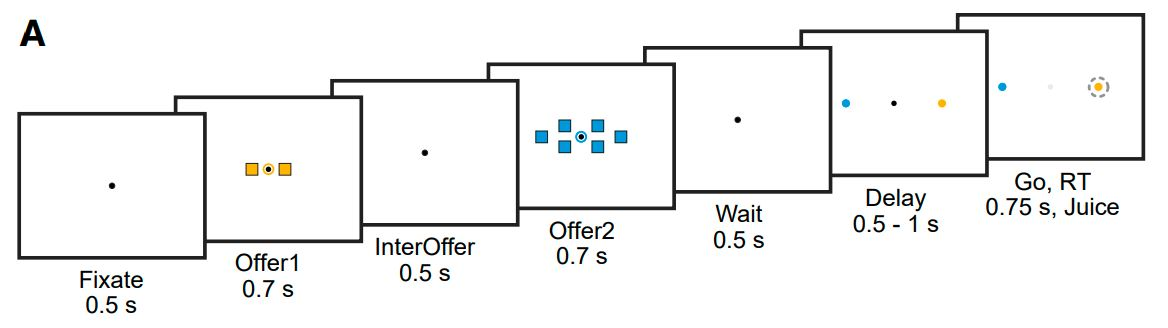

In [ ]:
from IPython.display import Image, display
print('Sequential Offer Task (Ballesta and Padoa-Schioppa, 2019)')
!git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
display(Image('LogisticRegression_tutorial/pics/SO_tasks.jpg', width=400, unconfined=True)) # use it only for google colab
# display(Image('../pics/SO_tasks.jpg', width=600, unconfined=True))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

## Step 1: load data

First, let's load example data file named as `goodTrials_SO.mat`. It only contains trials that monkey has successfully chosen one of the juice option.  

`goodTrials_SO.mat` is a $N \times 5$, where $N$ is the number of the trials in this session, and in this example, $N =242$. The columns of this matrix indicated:

 - *column 1*: the trial number.

 - *column 2*: the quantity of juice A. The negative sign indicated that A is presented first.
 
 - *column 3*: the quantity of juice B. The negative sign indicated that B is presented first.
 
 - *column 4*: the side of target location, with 1 indicating A on the left side.
 
 - *column 5*: the chosen juice type, with 1 indicating A and 2 indicating B.


In [ ]:
# !git clone https://github.com/wilburshi/LogisticRegression_tutorial.git # use it only for google colab 
data = loadmat('LogisticRegression_tutorial/data/goodtrials_SO.mat')['goodTrials_SO'] # use it only for goole colab
# data = loadmat('../data/goodtrials_SO.mat')['goodTrials_SO'] # loadmat is a function in scipy.io used to load Matlab data file

# Independent variables
QA = np.abs(data[:,1]) # quantity of juice A
QB = np.abs(data[:,2]) # quantity of juice B
SideA = np.abs(data[:,3])*2-3 # side of target A. -1: left, 1: right
OrdA = -np.sign(data[:,1]) # side of target A. -1: BA, 1: AB 

# Dependent variables
CJ = data[:,4]-1 # the type of chosen juice. 0: chosen A, 1: chosen B

ind_forced = (data[:,1] == 0) | (data[:,2] == 0) # index of forced choice
ind_nonforced = ~ind_forced

## Step 2: probit regression fitting
we used probit regression to fit the choice pattern. the model was as follows:

$ choice B = \Phi(X) $

$ X = a_0 + a_1 log(q_B/q_A) + a_2 (\delta_{AB} - \delta_{BA})$

where $choice B = 1$ if juice B is chosen and 0 otherwise. $\Phi$ is the cumulative function of a Gaussian distribution (probit link). $q_A$ and $q_B$ are the juice quantity for A and B in each trial. $\delta_{AB} = 1$ for AB trial and 0 otherwise, and $\delta_{BA} = 1$ for BA trial and 0 otherwise. $a_0$, $a_1$ and $a_2$ are the fitted parameters, from which we define the relative value ($\rho$) between A and B as $\rho = exp(-a_0/a_1)$, the sigmoid steepness ($\eta$) as $\eta = a_1$ and the order bias $\epsilon$ as $\epsilon = a_2$. Relative value measures the indifference point at which the value of A and B are the same, that is, $1 q_A = \rho q_B$; steepness reflects the choice accuracy which is inverse to the choice variability; order bias quantifies the choice bias in favor of the first or the second offer. Specifically, $epsilon > 0$ indicated a favor towards offer 2, and $epsilon < 0$  indicated a favor towards offer 1. We can further define relative value separately for AB and BA trials: $\rho_{AB} = exp(-(a_0+a_2)/a_1)$; $\rho_{BA} = exp(-(a_0-a_2)/a_1)$.

In [ ]:
from statsmodels.discrete.discrete_model import Probit
from statsmodels.discrete.discrete_model import Logit

In [ ]:
# remove the forced choice (0A or 0B)
Y = CJ[ind_nonforced]
X1 = np.log(QB[ind_nonforced]/QA[ind_nonforced])
X2 = OrdA[ind_nonforced]
const = np.ones(X1.shape)

# probit regression
model = Probit(Y, np.transpose([const, X1, X2]))
probit_model = model.fit()
betas = probit_model.params
# print(probit_model.summary())

Optimization terminated successfully.
         Current function value: 0.422054
         Iterations 6


## Step 3: plotting
We plot the choice patterns as percentage of choice B v.s. offer types (defined by the two quantities). We separate the AB and BA trials. We also exclude the forced choice for convenience.

In [ ]:
# We plot the choice patterns as percentage of choice B v.s. offer types (defined by the two quantities)
def OfferTypeTable(alltrials,allchoice):
    # calculate offer types
    table01 = np.unique(alltrials,axis = 1)
    LogRatio = np.log(table01[0,:]/table01[1,:])
    ntritype = np.shape(table01)[1]
    
    # calculate the percentage of choice B #
    PB = np.array([]) # percentage of choice B
    xtickname = np.array([]) # x axis tick names
    for itritype in np.arange(0, ntritype,1):
        ind_itritype = (np.transpose(alltrials) == np.transpose(table01)[itritype,:]).all(axis=1)
        CJ_itritype = allchoice[ind_itritype]
        PB_itritype = np.sum(CJ_itritype)/(np.shape(CJ_itritype)[0])
        PB = np.append(PB,PB_itritype)
        xtickname_itritype = np.array2string(table01[0,itritype])+'/'+np.array2string(table01[1,itritype])
        xtickname = np.append(xtickname,xtickname_itritype)
    
    return (LogRatio, PB, xtickname)

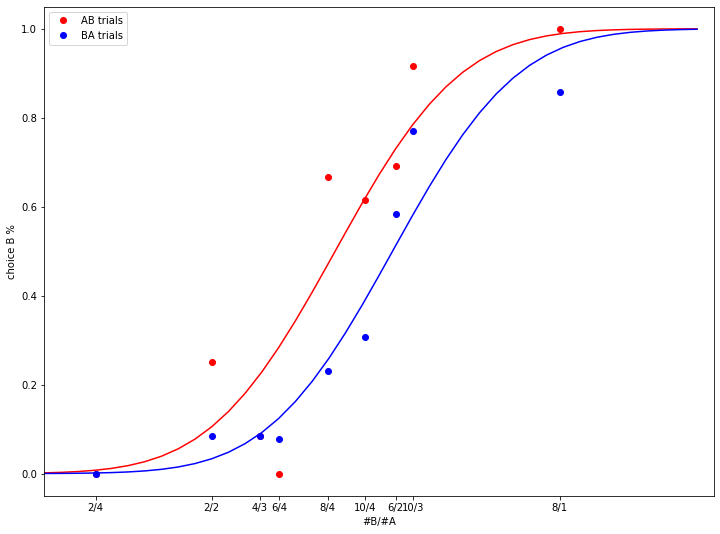

In [ ]:
#####
# plot the results #
#####
# calculate offer types

# for AB trials
(LogRatio_AB, PB_AB, xtickname_AB) = OfferTypeTable([QB[ind_nonforced & (OrdA ==  1)], QA[ind_nonforced & (OrdA ==  1)]], CJ[ind_nonforced & (OrdA ==  1)])
# for BA trials
(LogRatio_BA, PB_BA, xtickname_BA) = OfferTypeTable([QB[ind_nonforced & (OrdA == -1)], QA[ind_nonforced & (OrdA == -1)]], CJ[ind_nonforced & (OrdA == -1)])
    
# plot sigmoidal curve     
X_plot = np.arange(np.floor(np.min(LogRatio_AB)), np.ceil(np.max(LogRatio_AB)), 0.1)
const_plot = np.ones(np.size(X_plot))
AB_plot = np.ones(np.size(X_plot))
BA_plot = -np.ones(np.size(X_plot))
Y_plot_AB = probit_model.predict(np.transpose([const_plot, X_plot, AB_plot]))
Y_plot_BA = probit_model.predict(np.transpose([const_plot, X_plot, BA_plot]))

# plot
fig= plt.figure(figsize=(12,9))
plt.plot(LogRatio_AB, PB_AB, 'ro')
plt.plot(LogRatio_BA, PB_BA, 'bo')
plt.plot(X_plot,Y_plot_AB, 'r')
plt.plot(X_plot,Y_plot_BA, 'b')
plt.legend(["AB trials", "BA trials"])
plt.axis([-1,3,-0.05,1.05])
plt.xlabel("#B/#A")
plt.ylabel("choice B %");
ax = plt.gca() 
ax.set_xticks(LogRatio_AB)
ax.set_xticklabels(xtickname_AB); 

In [ ]:
rho_AB = np.exp(-(betas[0]+betas[2])/betas[1])
print('AB trial relative value ρ is: ', np.array2string(rho_AB))
rho_BA = np.exp(-(betas[0]-betas[2])/betas[1])
print('BA trial relative value ρ is: ', np.array2string(rho_BA))
epsilon = betas[2]
print('Order bias 𝜖 is: ', np.array2string(epsilon))

AB trial relative value ρ is:  2.09188112
BA trial relative value ρ is:  2.94776639
Order bias 𝜖 is:  0.29132639
